In [6]:
# Model Performance Verification
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report, 
    confusion_matrix,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

print("🔍 VERIFYING MODEL PERFORMANCE")
print("="*80)

# Load saved model
model_path = '../models/fraud_detector_xgboost.pkl'
model = joblib.load(model_path)
print(f"✅ Model loaded from: {model_path}")

# Load metadata
with open('../models/model_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"\n📋 Saved Metadata (from training):")
print(f"   Training Date: {metadata['model_info']['training_date']}")
for metric, value in metadata['performance'].items():
    print(f"   {metric}: {value:.4f}")

🔍 VERIFYING MODEL PERFORMANCE
✅ Model loaded from: ../models/fraud_detector_xgboost.pkl

📋 Saved Metadata (from training):
   Training Date: 2026-02-10 15:28:53
   accuracy: 0.9984
   precision: 0.5319
   recall: 0.8446
   f1_score: 0.6527
   roc_auc: 0.9751


In [7]:
# Load data and test again
print("\n🔄 RE-TESTING ON SAME SPLIT...")
print("="*80)

# Load dataset
df = pd.read_csv('../data/creditcard.csv')

# Feature engineering (MUST match training exactly)
df['Hour'] = (df['Time'] / 3600) % 24
df['Amount_Log'] = np.log1p(df['Amount'])

# Prepare features
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class']

# SAME split as training (random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print(f"✅ Data prepared")
print(f"   Test set size: {len(X_test)}")
print(f"   Actual frauds: {y_test.sum()}")

# Get predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f"   Predicted frauds: {y_pred.sum()}")


🔄 RE-TESTING ON SAME SPLIT...
✅ Data prepared
   Test set size: 85443
   Actual frauds: 148
   Predicted frauds: 235


In [8]:
# Calculate actual metrics
print("\n📊 ACTUAL CURRENT PERFORMANCE:")
print("="*80)

# Calculate all metrics
actual_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba)
}

# Print comparison
print("\n{:<20} {:<15} {:<15} {:<15}".format(
    "METRIC", "SAVED", "ACTUAL", "DIFFERENCE"
))
print("-"*65)

for metric in actual_metrics.keys():
    saved = float(metadata['performance'][metric])
    actual = float(actual_metrics[metric])
    diff = actual - saved
    
    print("{:<20} {:<15.4f} {:<15.4f} {:+15.4f}".format(
        metric.upper(), saved, actual, diff
    ))

print("="*80)

# Detailed classification report
print("\n📋 DETAILED CLASSIFICATION REPORT:")
print("="*80)
print(classification_report(
    y_test, y_pred,
    target_names=['Normal', 'Fraud'],
    digits=4
))



📊 ACTUAL CURRENT PERFORMANCE:

METRIC               SAVED           ACTUAL          DIFFERENCE     
-----------------------------------------------------------------
ACCURACY             0.9984          0.9984                  +0.0000
PRECISION            0.5319          0.5319                  +0.0000
RECALL               0.8446          0.8446                  +0.0000
F1_SCORE             0.6527          0.6527                  +0.0000
ROC_AUC              0.9751          0.9751                  +0.0000

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal     0.9997    0.9987    0.9992     85295
       Fraud     0.5319    0.8446    0.6527       148

    accuracy                         0.9984     85443
   macro avg     0.7658    0.9217    0.8260     85443
weighted avg     0.9989    0.9984    0.9986     85443



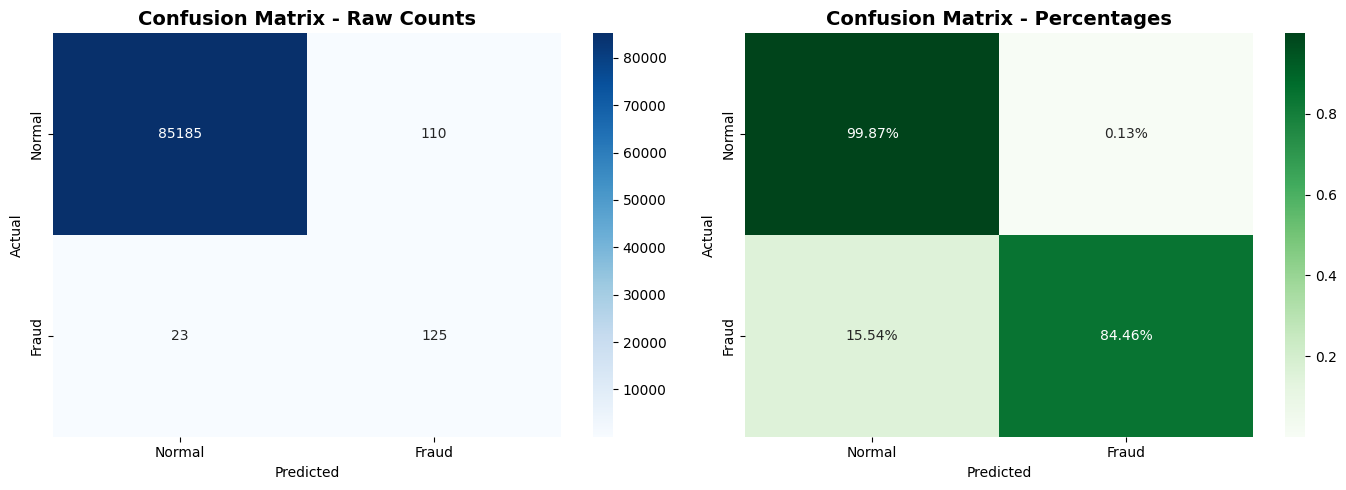


🔢 CONFUSION MATRIX BREAKDOWN:
   True Negatives (Normal → Normal):  85,185
   False Positives (Normal → Fraud):  110  ← False alarms
   False Negatives (Fraud → Normal):  23  ← Missed frauds
   True Positives (Fraud → Fraud):    125  ← Caught frauds

   Total Frauds: 148
   Caught: 125 (84.5%)
   Missed: 23 (15.5%)


In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
axes[0].set_title('Confusion Matrix - Raw Counts', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
axes[1].set_title('Confusion Matrix - Percentages', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# Breakdown
tn, fp, fn, tp = cm.ravel()
print("\n🔢 CONFUSION MATRIX BREAKDOWN:")
print(f"   True Negatives (Normal → Normal):  {tn:,}")
print(f"   False Positives (Normal → Fraud):  {fp:,}  ← False alarms")
print(f"   False Negatives (Fraud → Normal):  {fn}  ← Missed frauds")
print(f"   True Positives (Fraud → Fraud):    {tp}  ← Caught frauds")
print(f"\n   Total Frauds: {y_test.sum()}")
print(f"   Caught: {tp} ({tp/y_test.sum()*100:.1f}%)")
print(f"   Missed: {fn} ({fn/y_test.sum()*100:.1f}%)")

In [11]:
# Test threshold optimization results
print("\n🎯 THRESHOLD OPTIMIZATION CHECK:")
print("="*80)

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

results = []
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    results.append({
        'Threshold': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    print(f"Threshold {thresh:.1f}: Precision={precision:.2%}, Recall={recall:.2%}, F1={f1:.4f}")

# Find best F1
best_idx = max(range(len(results)), key=lambda i: results[i]['F1-Score'])
best_threshold = results[best_idx]['Threshold']
best_precision = results[best_idx]['Precision']
best_recall = results[best_idx]['Recall']

print("\n" + "="*80)
print(f"🏆 OPTIMAL THRESHOLD: {best_threshold}")
print(f"   Precision: {best_precision:.2%}")
print(f"   Recall:    {best_recall:.2%}")
print(f"   F1-Score:  {results[best_idx]['F1-Score']:.4f}")



🎯 THRESHOLD OPTIMIZATION CHECK:
Threshold 0.3: Precision=36.00%, Recall=85.14%, F1=0.5060
Threshold 0.4: Precision=45.65%, Recall=85.14%, F1=0.5943
Threshold 0.5: Precision=53.19%, Recall=84.46%, F1=0.6527
Threshold 0.6: Precision=61.88%, Recall=84.46%, F1=0.7143
Threshold 0.7: Precision=70.22%, Recall=84.46%, F1=0.7669
Threshold 0.8: Precision=75.15%, Recall=83.78%, F1=0.7923

🏆 OPTIMAL THRESHOLD: 0.8
   Precision: 75.15%
   Recall:    83.78%
   F1-Score:  0.7923
